# Trabalho de Regressão: Student exam score.


**Alunos:** Tales Araujo Kodama e Thiago Rovari

**Disciplina:** Inteligência Artificial - ECOM08A

### Introdução e Escolha do Dataset
Neste notebook visamos analisar como alguns fatores podem justificar a nota final de alunos em um teste.

**Dataset Escolhido:** Student Exam Score Dataset
 (Kaggle).

https://www.kaggle.com/datasets/grandmaster07/student-exam-score-dataset-analysis/data
* **Objetivo:** Prever a nota de um aluno com base nos fatores: horas de estudo, horas de sono, presença nas aulas e notas anteriores.


## 1. Declarando bibliotecas 

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error


## 2. Carregando dados
 Nesta etapa, carregamos o conjunto de dados student_exam_scores.csv, que contém informações de 96 estudantes, incluindo um identificador (student_id).
 Em seguida analisamos as primeiras 5 linhas para conferir se o carregamento do dataframe foi realizado corretamente.

In [ ]:
df = pd.read_csv('student_exam_scores.csv')
df = pd.DataFrame(df)

df['exam_score'] = (df['hours_studied']*2 + df['previous_scores']*0.6 + df['attendance_percent']*0.2) + np.random.normal(0, 2, len(df))

print("Visualização inicial dos dados:")
display(df.head())
print(f"\nTamanho do dataset: {df.shape}")

Visualização inicial dos dados:


,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
0,S001,8.0,8.8,72.1,45,55.713352
1,S002,1.3,8.6,60.7,55,49.767683
2,S003,4.0,8.2,73.7,86,72.275128
3,S004,3.5,4.8,95.1,66,68.088563
4,S005,9.1,6.4,89.8,71,80.883329



Tamanho do dataset: (200, 6)


## 3. Limpeza de Dados

A célula abaixo remove a coluna dos ID´s de cada estudante. Em seguida trata os dados, a fim de eliminar valores nulos e outliers. Assim contribuindo para o bom funcionamento dos algoritmos em seguida.

In [18]:

if 'student_id' in df.columns:
    df = df.drop('student_id', axis=1)


colunas_numericas = df.select_dtypes(include=['number']).columns
df[colunas_numericas] = df[colunas_numericas].fillna(df[colunas_numericas].mean())


def remover_outliers(dataframe, colunas):
    df_clean = dataframe.copy()
    for col in colunas:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        limite_inferior = Q1 - 1.5 * IQR
        limite_superior = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= limite_inferior) & (df_clean[col] <= limite_superior)]
    return df_clean


df_limpo = remover_outliers(df, df.columns)
print(f"Linhas antes da remoção de outliers: {len(df)}")
print(f"Linhas após a remoção de outliers: {len(df_limpo)}")

Linhas antes da remoção de outliers: 200
Linhas após a remoção de outliers: 200


## 4.Análise Exploratória
Nesta etapa, realizamos uma análise exploratória dos dados para compreender melhor a distribuição das variáveis e suas relações com a nota da prova (exam_score).​

São construídos gráficos como histogramas, mapas de calor de correlação e diagramas de dispersão entre exam_score e as variáveis de entrada.

Com base nessas visualizações, discutimos quais atributos parecem ter maior influência sobre o desempenho dos estudantes e se há indícios de relações não lineares que possam favorecer modelos mais complexos, como árvore de decisão ou MLP.

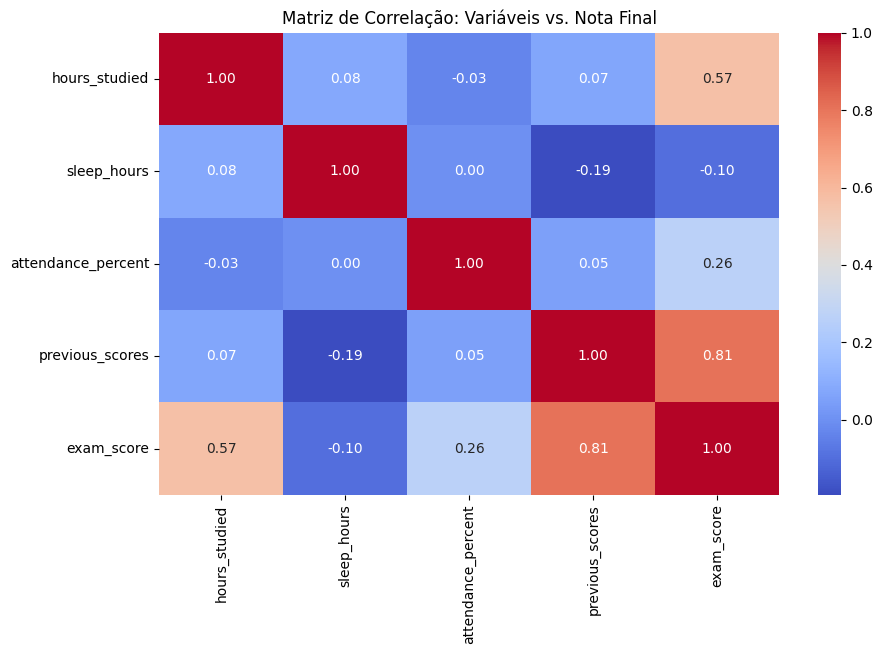

In [12]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df_limpo.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlação: Variáveis vs. Nota Final')
plt.show()

## 5.Divisão e Normalização
 Separamos os dados em conjuntos de treino (para aprendizado) e teste (para validação final). Em seguida, aplicamos a normalização MinMaxScaler para colocar todos os dados entre 0 e 1.

In [20]:

X = df_limpo.drop('exam_score', axis=1)
y = df_limpo['exam_score']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## 6.Treinamento e Avaliação dos Modelos
  Regressão Linear, Árvore de Decisão, SVM e MLP. Calculamos as métricas de erro (MAE, MSE, RMSE, MAPE) e o coeficiente de determinação ($R^2$) para avaliar a generalização.

In [21]:

resultados = []


modelos = {
    'Regressão Linear': LinearRegression(),
    'Árvore de Decisão': DecisionTreeRegressor(random_state=42),
    'SVM (SVR)': SVR(kernel='linear'),
    'MLP (Rede Neural)': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
}

#Iniciando treinamento

for nome, modelo in modelos.items():
    
    modelo.fit(X_train_scaled, y_train)
    
    
    y_pred = modelo.predict(X_test_scaled)
    
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
   
    resultados.append({
        'Modelo': nome,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': f"{mape:.2%}",
        'R2 Score': r2
    })
    
    print(f"{nome} treinado. R2: {r2:.4f}")


df_resultados = pd.DataFrame(resultados).sort_values(by='R2 Score', ascending=False)
display(df_resultados)

Regressão Linear treinado. R2: 0.9728
Árvore de Decisão treinado. R2: 0.8854
SVM (SVR) treinado. R2: 0.9195
MLP (Rede Neural) treinado. R2: 0.9716


c:\Users\Thiago\vscode\UNIFEI2025\IA_JoaoPaulo\.venv2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


,Modelo,MAE,MSE,RMSE,MAPE,R2 Score
0,Regressão Linear,1.665407,4.683661,2.164177,2.71%,0.972798
3,MLP (Rede Neural),1.708649,4.882028,2.209531,2.76%,0.971646
2,SVM (SVR),3.170250,13.859787,3.722873,5.25%,0.919505
1,Árvore de Decisão,3.504854,19.734497,4.442353,5.75%,0.885385


## 7.Comparação Visual
 Visualizamos o desempenho dos modelos comparando o $R^2$

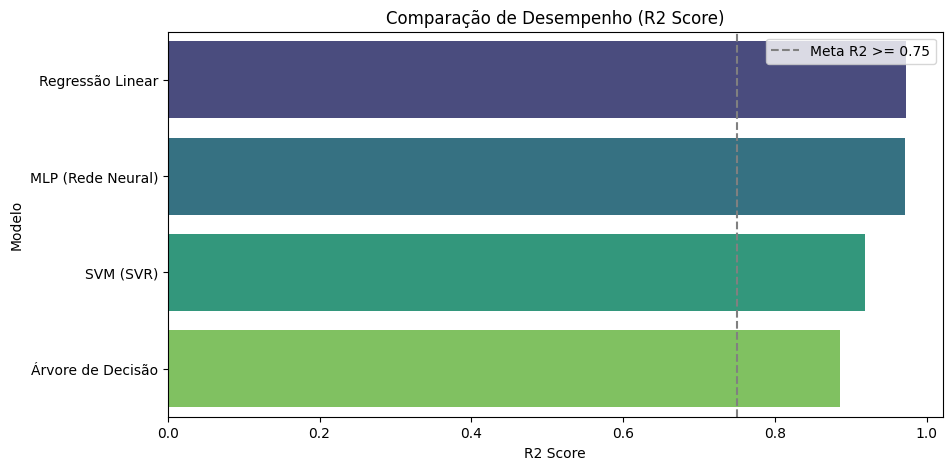

In [24]:
plt.figure(figsize=(10, 5))
sns.barplot(x='R2 Score', y='Modelo', hue='Modelo', data=df_resultados, palette='viridis', legend=False)
plt.axvline(0.75, color='gray', linestyle='--', label='Meta R2 >= 0.75') 
plt.title('Comparação de Desempenho (R2 Score)')
plt.legend() 
plt.show()